# Poisson's equation

Now extend your solver to solve for Poisson's equation.
* Consider a 64 x 64 grids in a domain ($-1<x<1$ and $-1<y<1$)
* Assume $\rho(r)= \exp(-10r)$
* Assume $u$ is zero on the four boundaries.
* Solver for the potential $u$.
* What is the corresponding electrical (or gravitational) field? (Hints: use `numpy.gradient()`)

In [49]:
import numpy as np
from scipy.sparse import dia_array  # if dia_array is not able, use dia_matrix
from scipy.sparse import dia_matrix
from scipy.sparse import csc_matrix
import scipy.sparse.linalg as splinalg
from numba import jit, njit, prange
import matplotlib.pyplot as plt
from numba import set_num_threads
nthreads = 8
set_num_threads(nthreads)

In [50]:
# Copy your Laplace's Equation solver from demo1 here
def generate_the_laplace_matrix_with_size(N=4):
    """
    assume sqrt(N) is an integer.

    """
    nsq = N*N
    A   = np.zeros((nsq,nsq)) 
 
    id_matrix=-np.identity(N)
    
    zero_matrix=np.zeros((N,N))
    
    ex=np.ones(N)
    data=np.array([-ex,4*ex,-ex])
    offsets=np.array([-1,0,1])
    main_matrix=dia_array((data,offsets),shape=(N,N)).toarray() 
          
    init_matrix_kernel(N,A,zero_matrix,id_matrix,main_matrix)

    return A

@njit(parallel=True)
def init_matrix_kernel(N,A,zero_matrix,id_matrix,main_matrix):
    for i in range(N):
        for j in range(N):
            
            if i==j:
                submatrix=main_matrix
            elif abs(i-j)==1:
                submatrix=id_matrix
            else:
                submatrix=zero_matrix
                
            for ii in range(N):
                for jj in range(N):
                    A[i*N+ii][j*N+jj]=submatrix[ii][jj]
                    
    return A

def convert_solution(x):
    usize = np.sqrt(len(x))
    u = x.reshape(int(usize),int(usize)).transpose()
    return u




The right hand side vector need to be updated when there is a density field $\rho$.
First, we write a function `generate_rho()` to generate the $N \times N$ density field.

In [51]:
def generate_rho(N, xmin=-1, xmax=1, ymin=-1,ymax=1):
    # TODO:
    x=np.linspace(xmin,xmax,N)
    y=np.linspace(ymin,ymax,N)
    
    xx,yy=np.meshgrid(x,y, indexing='ij')
    r=np.sqrt(xx**2+yy**2)
    rho=np.exp(-10*r)    

    return rho

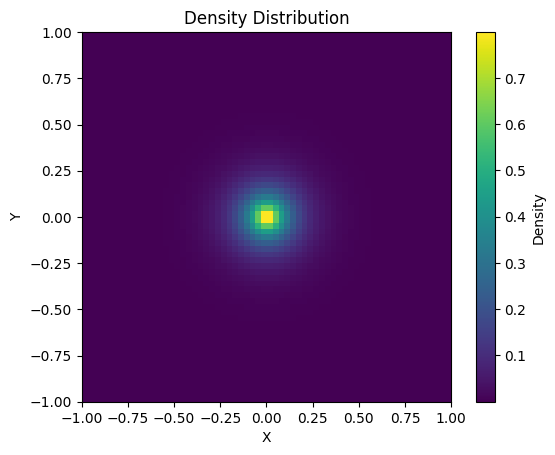

In [52]:
# Visualize the density field
rho = generate_rho(N=64)
plt.imshow(rho, extent=[-1, 1, -1, 1], origin='lower')
plt.colorbar(label='Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Density Distribution')
plt.show()

Once we have the density filed, we need to modify the `generate_the_rhs_vector_with_size()` to include the density field.

In [53]:
def generate_the_rhs_vector_with_size(N=4, rho=None, dx=1):
    
    #TODO:
    if rho is None:
        b = np.zeros(N*N)
        b[-N:]=1
    else:
        b=rho.flatten()
        b=-b*dx**2
        b[-N:]=b[-N:]+0

    return b

We could solve the system by the same way in `solve_laplace()`.

In [54]:
def solve_laplace(N=16):
    A = generate_the_laplace_matrix_with_size(N=N)

    rho = generate_rho(N=N)
    b = generate_the_rhs_vector_with_size(N=N, rho=rho, dx=2/(N-1))
    #x = linalg.solve(A,b) # use scipy
    #x = lu_solve(A,b)      # use our solver
    x = splinalg.spsolve(A,b) # use scipy sparse solver
    u = convert_solution(x)
    return u

In [55]:
u = solve_laplace(N=64)

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\core\typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "..\..\..\AppData\Local\Temp\ipykernel_10408\861293346.py", line 23:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,
C:\Users\Asus\AppData\Local\Temp\ipykernel_10408\3917867856.py:8: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  x = splinalg.spsolve(A,b) # use scipy sparse solver


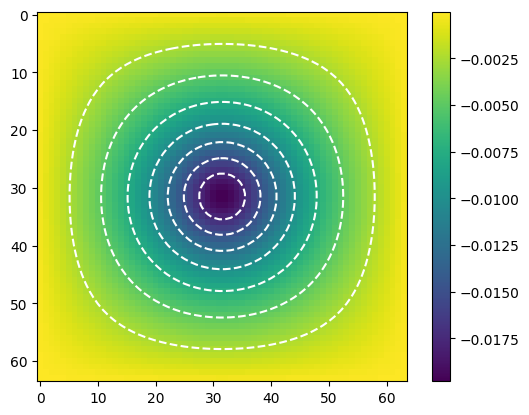

In [60]:
# Visualize the solution
plt.imshow(u)
plt.colorbar()
plt.contour(u,colors="w")

Calculate the gravitational field

In [57]:
phi =np.gradient(u)

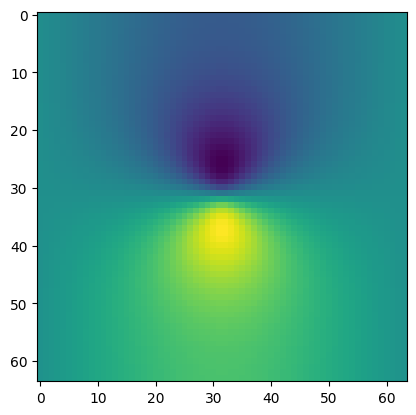

In [58]:
plt.imshow(phi[0]) # x derivative

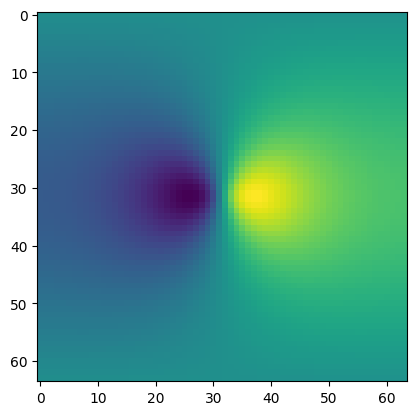

In [59]:
plt.imshow(phi[1]) # y derivative